## 9.Can we use number of posts in Pokémon subreddits to predict the stock price of Nintendo?

Business goal: Perform time series analysis and build a time series model to predict Nintendo stock price using number of posts in Pokémon subreddits.

Technical proposal: Gather Nintendo stock data from January 2021 to August 2022 from Yahoo Finance. Full outer Join the stock data with the time series data created in Question 2. Fill missing values in joint data with linear interpolation. Train a VAR (vector autoregression) model to predict stock price. Present result by a graph showing actual vs. predicted data.

In [0]:
import pandas as pd
# read time series data
df = pd.read_csv('../../data/csv/timeseries_subreddits_stocks.csv', index_col="date")
df.sort_index(inplace=True)
df

,pokemontrades,pokemon,pokemongo,PokemonTCG,PokemonSwordAndShield,PokemonMasters,PokemonUnite,PokemonLegendsArceus,PokemonBDSP,Close,Volume
date,,,,,,,,,,,
2021-01-01,3162,3298,1910,2153,2522,954,1.0,301.0,161.0,15.740000,3.369000e+06
2021-01-02,3662,3881,1682,2064,3306,544,1.0,301.0,161.0,15.740000,3.369000e+06
2021-01-03,3474,2720,1802,2285,3515,643,1.0,301.0,161.0,15.740000,3.369000e+06
2021-01-04,3099,7190,2030,3079,3099,1326,1.0,301.0,161.0,15.740000,3.369000e+06
2021-01-05,3273,5354,1687,2682,2576,688,1.0,301.0,161.0,16.176001,1.448500e+06
...,...,...,...,...,...,...,...,...,...,...,...
2022-08-27,1900,4686,5281,2426,2523,2009,1452.0,303.0,197.0,10.410000,2.135167e+06
2022-08-28,2245,21951,4187,2489,2396,2382,1292.0,506.0,154.0,10.380000,1.742833e+06
2022-08-29,2085,8077,5366,2426,2017,2930,2653.0,569.0,286.0,10.350000,1.350500e+06


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

## Granger’s Causality Test

In [0]:
# Granger’s Causality Test
from statsmodels.tsa.stattools import grangercausalitytests

df1 = pd.DataFrame(np.zeros((len(df.columns), len(df.columns))), columns=df.columns, index=df.columns)
for col in df1.columns:
    for row in df1.index:
        test_result = grangercausalitytests(df[[row, col]], maxlag=7, verbose=False)
        p_values = [round(test_result[i+1][0]["ssr_chi2test"][1], 4) for i in range(7)]
        p_value = min(p_values)
        df1.loc[row, col] = p_value
df1

,pokemontrades,pokemon,pokemongo,PokemonTCG,PokemonSwordAndShield,PokemonMasters,PokemonUnite,PokemonLegendsArceus,PokemonBDSP,Close,Volume
pokemontrades,1.0000,0.0002,0.1739,0.1401,0.0004,0.1584,0.4860,0.4285,0.0000,0.5236,0.5910
pokemon,0.0001,1.0000,0.0032,0.0001,0.0254,0.0149,0.0033,0.0008,0.0041,0.0045,0.3909
pokemongo,0.1523,0.7674,1.0000,0.6807,0.1775,0.1391,0.0201,0.3511,0.7188,0.0000,0.1803
PokemonTCG,0.1269,0.0340,0.6584,1.0000,0.0000,0.1924,0.0034,0.5962,0.0455,0.0002,0.4606
PokemonSwordAndShield,0.0000,0.3726,0.4499,0.0048,1.0000,0.0096,0.0000,0.0060,0.0223,0.5301,0.1763
PokemonMasters,0.1102,0.1031,0.0381,0.4215,0.0017,1.0000,0.0013,0.0587,0.1476,0.0637,0.1340
PokemonUnite,0.8637,0.1289,0.0329,0.0349,0.3117,0.0326,1.0000,0.1034,0.0001,0.0511,0.0003
PokemonLegendsArceus,0.4009,0.2197,0.5806,0.4671,0.1581,0.0064,0.3756,1.0000,0.5841,0.0779,0.4356
PokemonBDSP,0.0000,0.0073,0.2254,0.0001,0.0003,0.0037,0.0351,0.7147,1.0000,0.0006,0.3033
Close,0.3041,0.0313,0.0006,0.6883,0.2509,0.1654,0.0104,0.3759,0.8258,1.0000,0.2607


The table above shows the p-values of Granger’s Causality Test. The null hypothesis is that event A doesn’t cause event B. If the p-value is smaller than 0.05, we should reject the null and conclude that event A causes event B. We focus on causality of between each subreddit close price. "pokemontrades", "PokemonSwordAndShield", "PokemonMasters", "PokemonUnite" "PokemonLegendsArceus" have p-values bigger than 0.05, so they don't have causality with close price. We will remove these columns for future analysis.

In [0]:
# drop columns
df.drop(columns=["pokemontrades", "PokemonSwordAndShield", "PokemonMasters", "PokemonUnite", "PokemonLegendsArceus"], inplace=True)
df

,pokemon,pokemongo,PokemonTCG,PokemonBDSP,Close,Volume
date,,,,,,
2021-01-01,3298,1910,2153,161.0,15.740000,3.369000e+06
2021-01-02,3881,1682,2064,161.0,15.740000,3.369000e+06
2021-01-03,2720,1802,2285,161.0,15.740000,3.369000e+06
2021-01-04,7190,2030,3079,161.0,15.740000,3.369000e+06
2021-01-05,5354,1687,2682,161.0,16.176001,1.448500e+06
...,...,...,...,...,...,...
2022-08-27,4686,5281,2426,197.0,10.410000,2.135167e+06
2022-08-28,21951,4187,2489,154.0,10.380000,1.742833e+06
2022-08-29,8077,5366,2426,286.0,10.350000,1.350500e+06


## Johansen Test of Cointegration

In [0]:
# Cointegration Test by Johansen Test
from statsmodels.tsa.vector_ar.vecm import coint_johansen
test_cointegration = coint_johansen(df,-1,5)
traces = test_cointegration.lr1
cvts = test_cointegration.cvt[:, 1]
df2 = pd.DataFrame(np.zeros((len(df.columns), 3)), columns=["Test Statistics", "Cointegration(95%)", "Significance"], index=df.columns)
for col, trace, cvt in zip(df.columns, traces, cvts):
    df2.loc[col, "Test Statistics"] = trace
    df2.loc[col, "Cointegration(95%)"] = cvt
    df2.loc[col, "Significance"] = trace > cvt
df2

,Test Statistics,Cointegration(95%),Significance
pokemon,193.213657,83.9383,True
pokemongo,122.554782,60.0627,True
PokemonTCG,64.473998,40.1749,True
PokemonBDSP,33.472139,24.2761,True
Close,12.071343,12.3212,False
Volume,2.359139,4.1296,False


The table above shows the Johansen Test of cointegration. The test result shows that number of comments in Pokémon subreddits have a long run statistically significant relationship. However, Close price and Volume doesn't have statistically significant relationship with other variables.

## Prepare training data and test data

In [0]:
# prepare training data and test data
# test data is 10 step prediction
df_train = df[:len(df) - 10]
df_test = df[len(df) - 10:]

## Check stationarity of data

In [0]:
# Augmented Dickey-Fuller Test of stationarity on original data
df3 = pd.DataFrame(np.zeros((len(df_train.columns), 3)), columns=["p-value", "Decision", "Stationary"], index=df_train.columns)
alpha = 0.05
for col in df_train.columns:
    test_adfuller = adfuller(df_train[col])
    p_value = round(test_adfuller[1], 4)
    df3.loc[col, "p-value"] = p_value
    if p_value < alpha:
        df3.loc[col, "Decision"] = "reject null"
        df3.loc[col, "Stationary"] = True
    else:
        df3.loc[col, "Decision"] = "don't reject null"
        df3.loc[col, "Stationary"] = False
df3

,p-value,Decision,Stationary
pokemon,0.0000,reject null,True
pokemongo,0.0000,reject null,True
PokemonTCG,0.1228,don't reject null,False
PokemonBDSP,0.0709,don't reject null,False
Close,0.4699,don't reject null,False
Volume,0.0000,reject null,True


Some variables in original data is not stationary, we should further process data.

In [0]:
# apply 1st order difference
# check stationarity
df_1st_diff = df_train.diff().dropna()
df4 = pd.DataFrame(np.zeros((len(df_1st_diff.columns), 3)), columns=["p-value", "Decision", "Stationary"], index=df_1st_diff.columns)
alpha = 0.05
for col in df_1st_diff.columns:
    test_adfuller = adfuller(df_1st_diff[col])
    p_value = round(test_adfuller[1], 4)
    df4.loc[col, "p-value"] = p_value
    if p_value < alpha:
        df4.loc[col, "Decision"] = "reject null"
        df4.loc[col, "Stationary"] = True
    else:
        df4.loc[col, "Decision"] = "don't reject null"
        df4.loc[col, "Stationary"] = False
df4

,p-value,Decision,Stationary
pokemon,0.0,reject null,True
pokemongo,0.0,reject null,True
PokemonTCG,0.0,reject null,True
PokemonBDSP,0.0,reject null,True
Close,0.0,reject null,True
Volume,0.0,reject null,True


All variables become stationary after 1st order difference.

## Train VAR model

In [0]:
model = VAR(df_1st_diff)

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


In [0]:
# check AIC and BIC for different lags
for i in range(1, 10):
    model_result = model.fit(i)
    result ={}
    result["AIC"] = model_result.aic
    result["BIC"] = model_result.bic
    print("Lag Order: ", i)
    print(result)

Lag Order:  1
{'AIC': 83.13095559305104, 'BIC': 83.44033496891807}
Lag Order:  2
{'AIC': 82.82333651180322, 'BIC': 83.3986437212697}
Lag Order:  3
{'AIC': 82.70090005027173, 'BIC': 83.54282638429082}
Lag Order:  4
{'AIC': 82.61881720346564, 'BIC': 83.72805693339761}
Lag Order:  5
{'AIC': 82.61069351380974, 'BIC': 83.98794390922937}
Lag Order:  6
{'AIC': 81.45206884209293, 'BIC': 83.09803018873278}
Lag Order:  7
{'AIC': 81.13223689045486, 'BIC': 83.04761250828561}
Lag Order:  8
{'AIC': 81.09384272797266, 'BIC': 83.27933898942183}
Lag Order:  9
{'AIC': 81.13529730589391, 'BIC': 83.59162365420437}


In [0]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,84.06,84.11,3.215e+36,84.08
1,83.20,83.51,1.353e+36,83.32
2,82.88,83.46,9.853e+35,83.11
3,82.75,83.60,8.686e+35,83.08
4,82.68,83.80,8.055e+35,83.11
5,82.67,84.06,8.019e+35,83.21
6,81.50,83.16,2.490e+35,82.15
7,81.18,83.10*,1.797e+35,81.93*
8,81.13*,83.32,1.713e+35*,81.98
9,81.16,83.63,1.772e+35,82.12


Lag 8 has the lowest AIC value, so we choose lag 8 to train model.

In [0]:
# train model using lag 8
model_var = model.fit(8)
model_var.summary()

Out[12]:   Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 04, Dec, 2022
Time:                     18:26:53
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    83.2793
Nobs:                     589.000    HQIC:                   81.9453
Log likelihood:          -28602.7    FPE:                1.65811e+35
AIC:                      81.0938    Det(Omega_mle):     1.02655e+35
--------------------------------------------------------------------
Results for equation pokemon
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  8.600384       138.872427            0.062           0.951
L1.pokemon            -0.584252         0.042851          -13.634           0.000
L1.pokemongo           0.321209         0.126

## Make forecast

In [0]:
# forecast after 1st difference
forecast_input = df_1st_diff.values[-model_var.k_ar:]
fc = model_var.forecast(y=forecast_input, steps=10)
df_forecast = pd.DataFrame(fc, index=df.index[-10:], columns=df.columns + '_1d')
df_forecast

,pokemon_1d,pokemongo_1d,PokemonTCG_1d,PokemonBDSP_1d,Close_1d,Volume_1d
date,,,,,,
2022-08-22,-2212.064063,886.532116,-175.800375,37.586479,0.022163,-64237.538604
2022-08-23,812.665931,-276.693503,168.591070,-117.356574,-0.007208,285097.846608
2022-08-24,-72.654020,-60.776069,51.537186,42.498193,0.032127,-387707.546160
2022-08-25,110.657799,51.359099,-30.131999,-133.716415,-0.011387,186011.913657
2022-08-26,-630.276169,165.069732,131.039731,-9.479121,-0.020511,187870.838513
2022-08-27,755.174137,-24.112755,-121.711857,81.796459,-0.049358,784.262661
2022-08-28,-381.716728,-53.924088,155.929118,89.406576,0.015359,-111157.962126
2022-08-29,-22.982639,-82.687623,-117.482606,39.444047,-0.012364,10589.218537
2022-08-30,117.382388,-45.541979,-21.296856,-102.449797,-0.004345,-29294.770778


The table above shows the forecaset after the 1st difference. We should invert this transformation to get real forecast.

In [0]:
# real forecast
df_fc = df_forecast.copy()
columns = df_train.columns
for col in columns:        
    # Roll back 1st Diff
    df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
df_fc = df_fc.iloc[:, len(columns):len(df_fc) + 2]
df_fc

,pokemon_forecast,pokemongo_forecast,PokemonTCG_forecast,PokemonBDSP_forecast,Close_forecast,Volume_forecast
date,,,,,,
2022-08-22,5350.935937,4225.532116,2220.199625,368.586479,10.902830,1.021929e+06
2022-08-23,6163.601867,3948.838614,2388.790695,251.229905,10.895622,1.307027e+06
2022-08-24,6090.947848,3888.062545,2440.327881,293.728098,10.927749,9.193194e+05
2022-08-25,6201.605647,3939.421644,2410.195882,160.011683,10.916361,1.105331e+06
2022-08-26,5571.329477,4104.491376,2541.235614,150.532562,10.895851,1.293202e+06
2022-08-27,6326.503614,4080.378621,2419.523757,232.329021,10.846492,1.293986e+06
2022-08-28,5944.786886,4026.454533,2575.452875,321.735597,10.861851,1.182828e+06
2022-08-29,5921.804248,3943.766910,2457.970269,361.179644,10.849487,1.193418e+06
2022-08-30,6039.186636,3898.224931,2436.673413,258.729847,10.845142,1.164123e+06


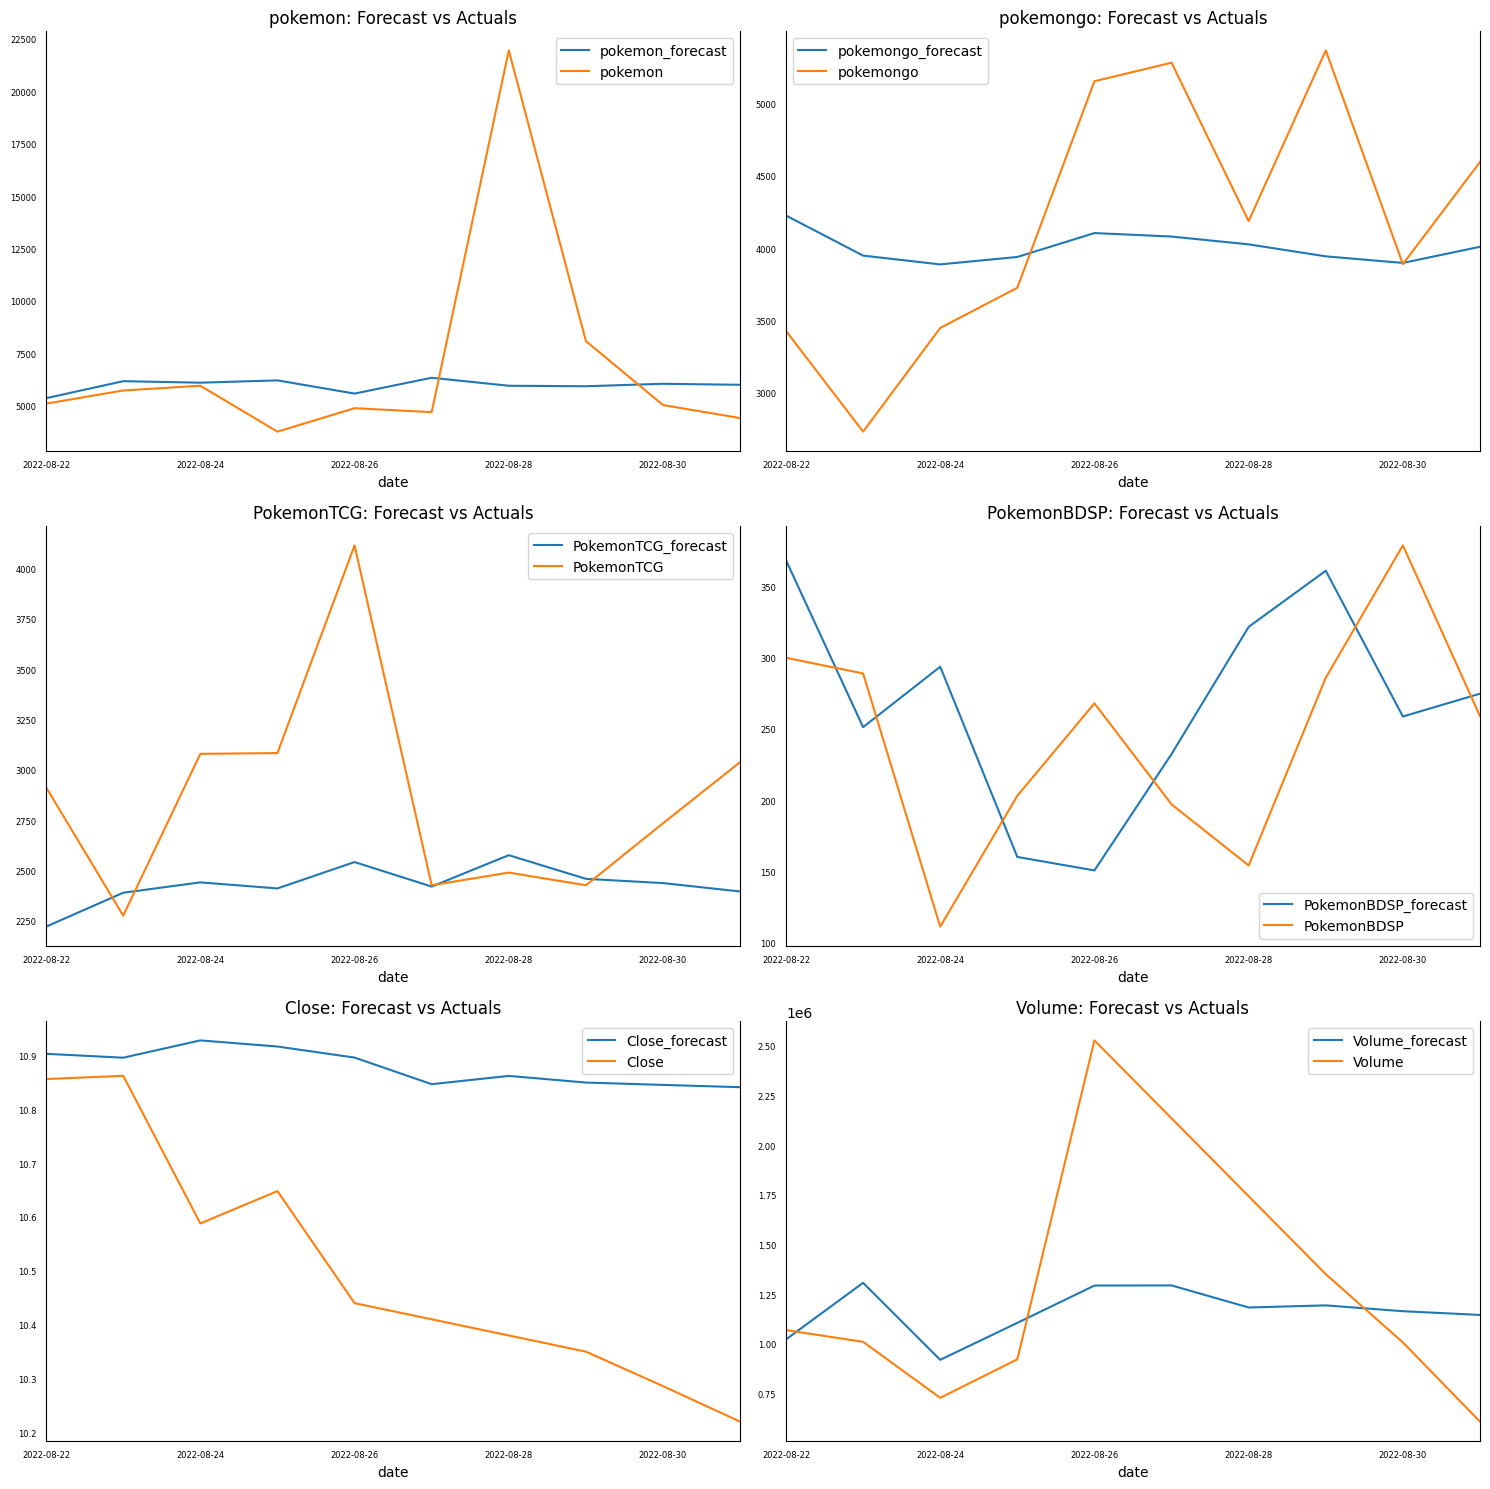

In [0]:
# plot forecast vs. actual
fig, axes = plt.subplots(nrows=int(len(df_fc.columns)/2), ncols=2, figsize=(15,15), dpi=100)
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_fc[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-10:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

In [0]:
# Plot forecast of future 10 days Nintendo stock price
import plotly.express as px
df_plot = df_fc.copy()
df_plot["Close"] = df_test["Close"]
df_plot.reset_index(inplace=True)

fig = px.line(df_plot, x="date", y=["Close", "Close_forecast"],
              hover_data={"date": "|%B %d, %Y"},
              title="Forecast of future 10 days Nintendo stock price")
fig.write_html("../../data/plots/stock_forecast.html")
fig.show()

In [0]:
# compute metrics for model evaluation
df_result = pd.DataFrame(np.zeros((len(df_fc.columns), 6)), columns=["MAPE", "ME", "MAE", "MPE", "RMSE", "Correlation"], index=df_fc.columns)
for col in df_fc.columns:
    column = col.split("_")[0]
    actual = df_test[column]
    predicted = df_fc[col]
    df_result.loc[col, "MAPE"] = np.mean(np.abs(predicted - actual)/np.abs(actual))
    df_result.loc[col, "ME"] = np.mean(predicted - actual)
    df_result.loc[col, "MAE"] = np.mean(np.abs(predicted - actual))
    df_result.loc[col, "MPE"] = np.mean((predicted - actual)/actual)
    df_result.loc[col, "RMSE"] = np.sqrt(np.mean((predicted - actual)**2))
    df_result.loc[col, "Correlation"] = np.corrcoef(predicted, actual)[0,1]
df_result

,MAPE,ME,MAE,MPE,RMSE,Correlation
pokemon_forecast,0.285645,-992.579682,2639.702092,0.086442,5233.023398,-0.038198
pokemongo_forecast,0.172514,-174.499688,708.915658,0.000202,853.375597,0.200435
PokemonTCG_forecast,0.146690,-429.252702,475.695470,-0.127104,658.823217,0.177978
PokemonBDSP_forecast,0.456521,22.683342,86.382542,0.236900,102.428418,0.050943
Close_forecast,0.036009,0.374227,0.374227,0.036009,0.420583,0.757870
Volume_forecast,0.315955,-147347.937450,420579.275940,0.043159,551674.619571,0.628947


To investigate if it's possible to use number of posts in Pokémon subreddits to predict the stock price of Nintendo, we train a vector autoregressive (VAR) model to predict number of comments in Pokémon subreddits and stock price. The plot above shows the forecast stock price by the model vs. actual stock price and table shows multiple metrics to evaluate forecast results. The actual stock price fluctuates during the predicted 10-day period which has several sudden changes from Aug 23 to Aug 26. The model cannot predict these changes and can only capture the trend of the stock. The metrics table shows that the model has very poor ability to predict number of comments in subreddits and it's surprising to see that the accuracy of predicting stock price is much higher. This may indicate that the number of comments in Pokémon subreddits have more randomness than the stock price, so it's very difficult for time series model to capture patterns. The RMSE of the predicted stock price is about 0.4206 which is about 3.6% of total stock price. Although the error seems small, we think it's not good enough considering the short period of prediction. Thus, we do not recommend using this model to guide the investment strategy.